# Data Exploration

Make sure to download and extract the `rba-dataset.csv` file from this Kaggle page: https://www.kaggle.com/datasets/dasgroup/rba-dataset

The data set is over 9gb, so we have to use dask dataframes to let it all fit in memory (unless you have a massive PC with 16gb of memory). It is a little annoying, so we might decide to work with a smaller sample of the data that is 500mb-1gb to make it more manageable. 

In [17]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import seaborn as sns

In [2]:
CSV_FILENAME = '../data/rba-dataset.csv'

In [20]:
df = dd.read_csv(CSV_FILENAME)

## How many successful and failed attempts are there by hour of day?

In [13]:
df['login_timestamp_dttm'] = dd.to_datetime(df['Login Timestamp'])
df['hour_of_day'] = df['login_timestamp_dttm'].dt.hour
df['count'] = 1
df_logins = df.groupby(['hour_of_day', 'Login Successful'])['count'].count().compute()
df_logins.head()

hour_of_day  Login Successful
0            False               335181
             True                106112
1            False               412196
             True                123122
2            False               511461
Name: count, dtype: int64

<AxesSubplot:xlabel='hour_of_day', ylabel='count'>

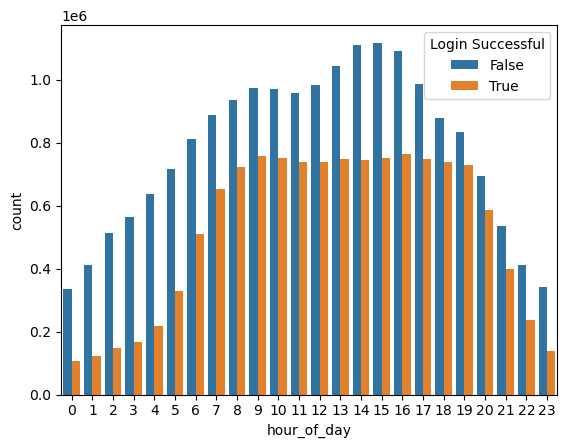

In [19]:
sns.barplot(
    data=df_logins.reset_index(), 
    x="hour_of_day", 
    y="count",
    hue='Login Successful'
)

In [8]:
df.head()

,index,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,ASN,User Agent String,Browser Name and Version,OS Name and Version,Device Type,Login Successful,Is Attack IP,Is Account Takeover
0,0,2020-02-03 12:43:30.772,-4324475583306591935,NaN,10.0.65.171,NO,-,-,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Firefox 20.0.0.1618,iOS 13.4,mobile,False,False,False
1,1,2020-02-03 12:43:43.549,-4324475583306591935,NaN,194.87.207.6,AU,-,-,60117,Mozilla/5.0 (Linux; Android 4.1; Galaxy Nexus...,Chrome Mobile 46.0.2490,Android 4.1,mobile,False,False,False
2,2,2020-02-03 12:43:55.873,-3284137479262433373,NaN,81.167.144.58,NO,Vestland,Urangsvag,29695,Mozilla/5.0 (iPad; CPU OS 7_1 like Mac OS X) ...,Android 2.3.3.2672,iOS 7.1,mobile,True,False,False
3,3,2020-02-03 12:43:56.180,-4324475583306591935,NaN,170.39.78.152,US,-,-,393398,Mozilla/5.0 (Linux; Android 4.1; Galaxy Nexus...,Chrome Mobile WebView 85.0.4183,Android 4.1,mobile,False,False,False
4,4,2020-02-03 12:43:59.396,-4618854071942621186,NaN,10.0.0.47,US,Virginia,Ashburn,398986,Mozilla/5.0 (Linux; U; Android 2.2) Build/NMA...,Chrome Mobile WebView 85.0.4183,Android 2.2,mobile,False,True,False
